# K-Means Clustering Analysis of Airbnb Data

This notebook performs K-means clustering analysis on Airbnb listing data to identify distinct groups of listings with similar characteristics.

## What is K-Means Clustering?

K-means is an unsupervised machine learning algorithm that groups similar data points together (clustering) by trying to separate samples into n groups of equal variance, minimizing a criterion known as inertia or within-cluster sum-of-squares. 

The algorithm works by:
1. Randomly selecting k initial centroids (k is specified by the user)
2. Assigning each data point to the nearest centroid
3. Recalculating the centroids as the mean of all points assigned to that cluster
4. Repeating steps 2-3 until the centroids no longer change significantly

For Airbnb data, clustering helps identify natural groupings in the marketplace - such as luxury properties, budget accommodations, or family-friendly options - which can provide insights for hosts, guests, and the platform itself.

## Setup and Data Loading

First, we import the necessary libraries for data manipulation, clustering, visualization and analysis. We use StandardScaler to normalize our features to have mean=0 and standard deviation=1, which ensures all features contribute equally to the clustering regardless of their original scales:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from IPython.display import display

Load the cleaned Airbnb dataset:

In [6]:
df = pd.read_csv("../data/cleaned_airbnb_data.csv")

## Finding Optimal Number of Clusters

One of the biggest challenges in K-means clustering is determining the optimal number of clusters (k). If k is too small, we might combine groups that should be separate; if k is too large, we might artificially split what should be one cohesive group.

### The Elbow Method: How It Works and Why We Use It

The elbow method is a visual and quantitative technique to find the appropriate number of clusters by plotting the inertia (within-cluster sum of squares) against different values of k. The process involves:

1. **Data preparation**: Selecting and standardizing numerical features to ensure each feature contributes equally to distance calculations
   - Standardization is crucial because features with larger scales (like price) would otherwise dominate the clustering compared to features with smaller scales (like ratings)

2. **Running K-means with different k values**: We try a range of k values (1-12) to see how the model performs with different numbers of clusters

3. **Calculating inertia for each k**: Inertia measures how internally coherent clusters are
   - Mathematically, it's the sum of squared distances between each point and its assigned cluster center
   - Lower inertia = points are closer to their centroids = more compact clusters
   - Inertia will always decrease as k increases (with k=n, each point could be its own cluster with zero inertia)

4. **Finding the 'elbow point'**: The point where adding another cluster gives diminishing returns
   - This appears as a bend or "elbow" in the plot where the rate of inertia decrease slows significantly
   - Intuitively, this is where we've captured most of the natural structure in the data

### Using a Percentage Improvement Threshold

Since eyeballing the elbow point can be subjective, we've added a simple percentage rule: when adding another cluster improves things by less than 8%, we stop there.

Why 8%? We tried several values:
- Higher values (10-15%) gave too few clusters, lumping together listings that seemed different
- Lower values (3-5%) created too many clusters with minimal differences
- 8% hit the sweet spot for our data, given the big jump between the 6th and 7th cluster.

This gives us a clear stopping rule while still respecting the visual elbow method. You can adjust this threshold in the code if needed.

### Feature Selection for Clustering

Choosing the right features for clustering is critical. We've selected features that capture different aspects of Airbnb listings:

- **Price metrics**: `realSum` - the actual price paid by guests, one of the most important factors in accommodation choice
- **Capacity and size**: `person_capacity`, `bedrooms` - indicate how many people can stay and the size of the property
- **Quality indicators**: `cleanliness_rating`, `guest_satisfaction_overall` - measure guest experience and property quality
- **Location metrics**: `dist` (distance to city center), `metro_dist` (distance to nearest metro/public transit) - location is a critical factor in accommodation value
- **Host characteristics**: `host_is_superhost_bool` - whether the host has achieved Airbnb's Superhost status (0=no, 1=yes), indicating reliability and quality
- **Booking attributes**: `Is_weekend_bool` - captures if the listing is mainly booked for weekends (0=no, 1=yes), suggesting different target travelers
- **Property type**: `room_private_bool` - distinguishes between private rooms (1) and entire properties (0)

Each of these features provides different information that helps the algorithm identify natural groupings in the data. The boolean features (ending with `_bool`) are encoded as 0/1 values, and K-means treats them as numerical distances just like other features. After standardization, these binary features will contribute meaningfully to the clustering based on their distribution in the dataset.

### Why We Need Standardization

K-means measures how similar listings are using distance calculations. Without standardization, our results would be skewed:
- Prices $(20-500) would overwhelm everything else
- Ratings (1-5 scale) would barely matter
- Yes/no features (0-1) would be practically ignored

Standardizing puts all features on equal footing, so a 1-star difference in ratings can be just as important as a $50 difference in price.

Improvement percentages for each additional cluster:
  k=2: 16.48% improvement
  k=3: 12.05% improvement
  k=4: 11.67% improvement
  k=5: 11.74% improvement
  k=6: 11.52% improvement
  --> Last value above 8% threshold
  k=7: 6.94% improvement
  k=8: 5.84% improvement
  k=9: 4.83% improvement
  k=10: 5.23% improvement


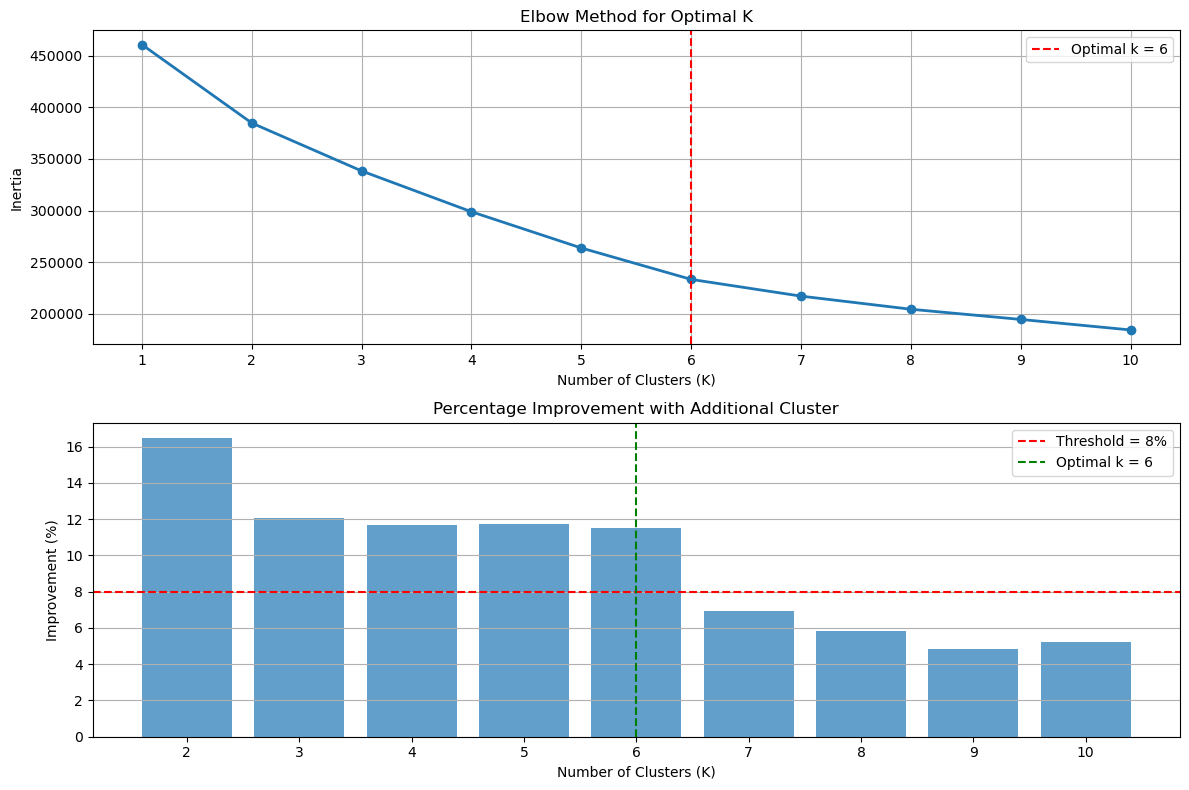

Automatically determined optimal k = 6 (last cluster with improvement >= 8%)


In [9]:
# Select numerical features for clustering
numerical_features = ['realSum', 'person_capacity', 'cleanliness_rating', 
                      'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
                      'host_is_superhost_bool','room_private_bool']

# Create a copy of the data with just numerical features
cluster_data = df[numerical_features].copy()

# Standardize the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Find the elbow point using the rate of change
inertia_array = np.array(inertia)
# Calculate percentage of change in inertia
inertia_diffs = np.diff(inertia_array) / inertia_array[:-1] * 100
# Convert to absolute values (since changes are negative)
inertia_diffs_abs = np.abs(inertia_diffs)

# Find the last k value where improvement is above the threshold
threshold = 8  # percentage improvement threshold
optimal_k = 2  # default to 2 if no clear elbow

# Identify the last k value where the improvement is above threshold
last_above_threshold = None
for i, diff_pct in enumerate(inertia_diffs_abs):
    k_value = i + 2  # k value is i+2 (since we're looking at differences and k starts at 1)
    if diff_pct >= threshold:
        last_above_threshold = k_value

# Set optimal_k to be the last k with improvement above threshold
if last_above_threshold is not None:
    optimal_k = last_above_threshold  # Use exactly the last k above threshold

# Print the actual improvement percentages for clarity
print("Improvement percentages for each additional cluster:")
for i, pct in enumerate(inertia_diffs_abs):
    k_val = i + 2  # k starts at 2 for diffs
    print(f"  k={k_val}: {pct:.2f}% improvement")
    if k_val == last_above_threshold:
        print(f"  --> Last value above {threshold}% threshold")

# Plot the elbow curve
plt.figure(figsize=(12, 8))

# Main plot - inertia
plt.subplot(2, 1, 1)
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.legend()

# Secondary plot - percentage improvement
plt.subplot(2, 1, 2)
plt.bar(range(2, len(k_range) + 1), inertia_diffs_abs, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}%')
# Mark the optimal k
plt.axvline(x=optimal_k, color='green', linestyle='--', 
           label=f'Optimal k = {optimal_k}')
plt.title('Percentage Improvement with Additional Cluster')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Improvement (%)')
plt.xticks(range(2, len(k_range) + 1))
plt.grid(True, axis='y')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Automatically determined optimal k = {optimal_k} (last cluster with improvement >= {threshold}%)")

## Performing K-Means Clustering

Based on the elbow analysis and our percentage improvement threshold criterion, we apply the K-means algorithm with the optimal number of clusters determined above. The exact number will vary depending on the data, but our algorithm has selected the most appropriate value based on when additional clusters stop providing substantial benefit (> 8% improvement):

In [11]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

## Analyzing Cluster Distribution by City

Cities have different Airbnb markets. Looking at how clusters spread across cities shows us:

- Which cities have more luxury or budget properties
- If some cities have similar property mixes
- Where certain property types are missing

This helps identify opportunities in different locations:

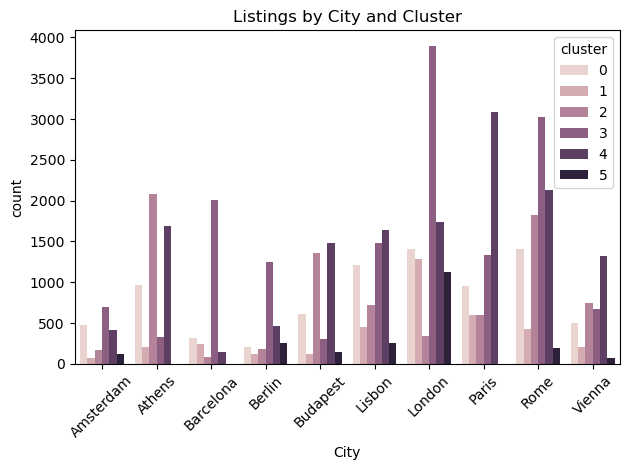

In [13]:
sns.countplot(data=df, x='City', hue='cluster')
plt.title("Listings by City and Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Examining Cluster Characteristics

After assigning each Airbnb listing to a cluster, we need to understand what makes each cluster distinct. A crucial step in cluster analysis is interpreting what each cluster represents in the real world.

### Understanding Cluster Statistics

We calculate summary statistics (means) for each feature within each cluster. This creates a "profile" for each cluster, helping us characterize what types of listings each cluster contains.

For example, a cluster with high values for:
- `realSum` (price) and `bedrooms` would suggest luxury or larger properties
- `cleanliness_rating` and `guest_satisfaction_overall` might represent high-quality accommodations
- Low `dist` and `metro_dist` would indicate centrally located properties

### Making Fair Comparisons Between Features

We need to compare apples to apples when looking at different features. Since prices range from $20-$500 while ratings are just 1-5, we use Z-scores to level the playing field:

1. **Convert to relative scores**: We measure how far each value is from average (in standard deviations)

2. **Scale everything to 0-1**: We then convert these scores to a simple 0-1 scale where 1 means "highest in this feature" and 0 means "lowest"

This makes it easy to see at a glance what makes each cluster special:

In [15]:
cluster_summary = df.groupby('cluster')[numerical_features].mean()
cluster_summary
df['cluster'].value_counts().sort_index()

cluster
0     8078
1     3729
2     8090
3    15014
4    14116
5     2162
Name: count, dtype: int64

## Detailed Cluster Analysis

To gain deeper insights into what makes each cluster unique, we need a more intuitive way to visualize and compare cluster characteristics across multiple dimensions simultaneously.

### Understanding Cluster Centers

Each cluster is represented by its centroid - the average position of all points in that cluster across all features. These centroids define the "prototype" or "typical example" of each cluster. 

We transform these centroids back to their original scale (undoing the standardization) to make them interpretable in real-world terms (actual prices, ratings, distances, etc.).

### Why Use a Radar Chart?

While tables with numbers are precise, they can be difficult to interpret at a glance. Radar charts (also called spider or web charts) provide a powerful visual alternative:

1. **Multi-dimensional visualization**: Each axis represents a different feature group
2. **Intuitive shape comparison**: The shape formed by each cluster creates a visual "fingerprint" 
3. **Feature grouping**: We combine related features to simplify the visualization
4. **Relative comparison**: The chart shows how clusters compare to each other on each dimension

### How Feature Grouping Works

To simplify the radar chart, we condense our 10 original features into 5 intuitive groups:

- **Distance**: Average of `dist` (distance to city center) and `metro_dist` (distance to public transit) 
- **Accommodation**: Average of `bedrooms` and `person_capacity` to represent property size
- **Quality**: Average of `cleanliness_rating` and `guest_satisfaction_overall` to represent overall experience
- **Price**: Using `realSum` directly as the sole price metric
- **Superhost**: Using `host_is_superhost_bool` directly

For each cluster, we calculate the average value for each feature group. For example, the Distance value for a cluster is the average of the mean `dist` and mean `metro_dist` values for all listings in that cluster. This grouping makes patterns more apparent while preserving the most important dimensions of variation.

### Interpreting the Radar Chart

In our radar chart:
- Each colored polygon represents one cluster
- Each axis represents a feature group (Distance, Accommodation, Quality, Price, Superhost)
- Higher values (closer to 1) mean that cluster scores highly on that feature group relative to other clusters
- The distinctive shape of each polygon helps identify the cluster's unique characteristics 

For example, a cluster with high values on Price and Quality but low on Distance might represent "Luxury properties further from city center" - this pattern is instantly visible in the radar chart's shape.

The combination of the detailed table and intuitive radar chart provides a comprehensive view of what makes each cluster distinct:

,realSum,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,host_is_superhost_bool,room_private_bool
Cluster 0,436.070000,4.930000,9.460000,93.300000,2.110000,2.790000,0.580000,0.110000,0.040000
Cluster 1,253.790000,2.910000,7.200000,71.720000,0.990000,3.380000,0.530000,0.010000,0.450000
Cluster 2,231.100000,3.500000,9.850000,97.090000,1.120000,2.330000,0.520000,1.000000,0.030000
Cluster 3,193.940000,2.210000,9.560000,94.050000,1.000000,3.450000,0.570000,0.240000,1.000000
Cluster 4,263.310000,3.040000,9.470000,93.450000,0.820000,2.690000,0.510000,-0.000000,-0.000000
Cluster 5,187.580000,2.780000,9.460000,93.960000,1.160000,9.230000,3.810000,0.230000,0.630000


Z-score normalized cluster means by feature group (scaled to [0,1] for visualization):


,Distance,Accommodation,Quality,Price,Superhost
Cluster 0,0.390000,0.970000,0.570000,0.970000,0.400000
Cluster 1,0.430000,0.400000,0.000000,0.480000,0.330000
Cluster 2,0.360000,0.530000,0.670000,0.420000,0.980000
Cluster 3,0.430000,0.280000,0.590000,0.320000,0.480000
Cluster 4,0.380000,0.390000,0.570000,0.510000,0.320000
Cluster 5,1.000000,0.410000,0.590000,0.300000,0.470000


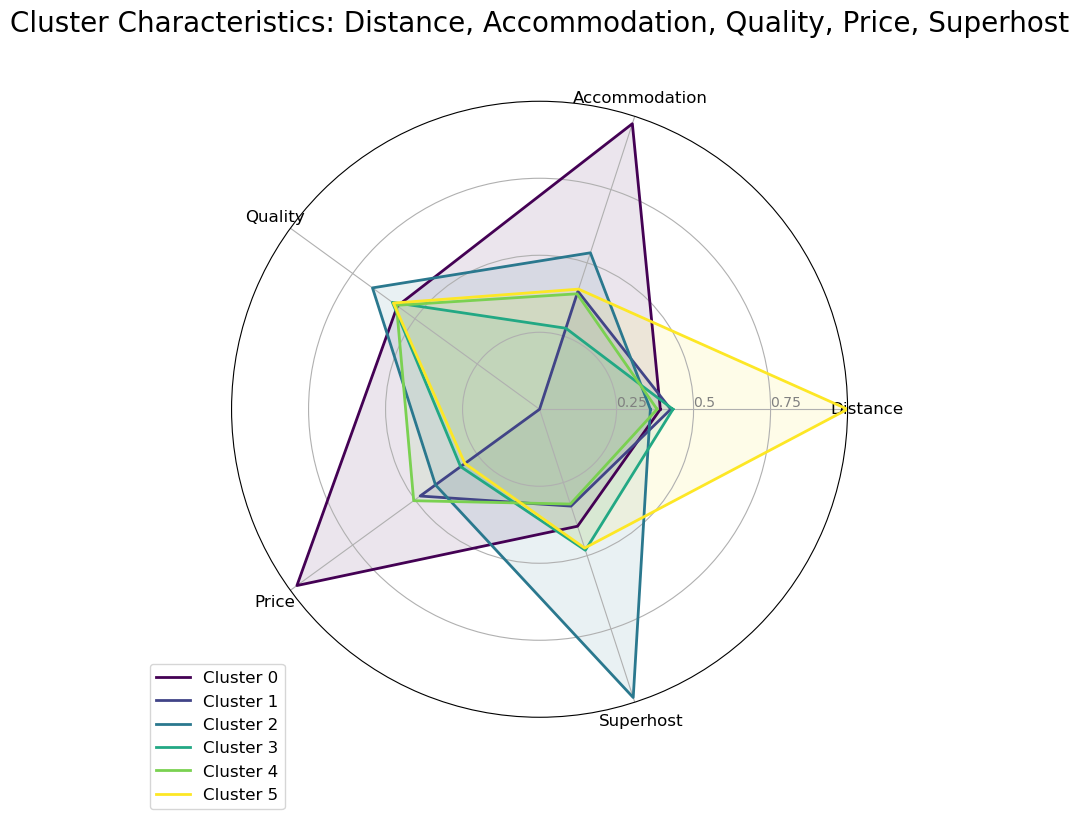

In [17]:
# Analyze the clusters
# Get the cluster centers and transform back to original scale
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)

# Create a DataFrame with the cluster centers
centers_df = pd.DataFrame(centers_original, columns=numerical_features)
centers_df.index = [f'Cluster {i}' for i in range(optimal_k)]

# Display the cluster centers using a clean styled table with alternating row colors
centers_df_styled = centers_df.round(2).style.set_caption("Cluster Centers (Original Scale)")\
    .set_properties(**{
        'text-align': 'center',
        'color': 'black',
    })\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-weight', 'bold'), ('font-size', '16px')]},
        {'selector': 'th', 'props': [
            ('text-align', 'center'), 
            ('background-color', '#d9d9d9'),
            ('color', 'black'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', 'white')]},
    ])

display(centers_df_styled)

# Visualize cluster characteristics with a radar chart
def radar_chart(df, title, colors=None):
    # Define feature groups
    feature_groups = {
        'Distance': ['dist', 'metro_dist'],
        'Accommodation': ['bedrooms', 'person_capacity'],
        'Quality': ['cleanliness_rating', 'guest_satisfaction_overall'],
        'Price': ['realSum'],
        'Superhost': ['host_is_superhost_bool']
    }
    
    # Create a new DataFrame to store group averages
    group_df = pd.DataFrame(index=df.index)
    
    # Calculate the average for each feature group
    for group_name, features in feature_groups.items():
        valid_features = [f for f in features if f in df.columns]
        if valid_features:
            group_df[group_name] = df[valid_features].mean(axis=1)
    
    categories = list(group_df.columns)
    N = len(categories)
    
    # Normalize the data for the radar chart
    normalized_df = pd.DataFrame(index=group_df.index, columns=group_df.columns)
    
    for col in group_df.columns:
        feature_values = group_df[col].values
        normalized_values = stats.zscore(feature_values)
        normalized_df[col] = normalized_values
    
    # Scale to [0,1] range
    min_val = normalized_df.values.min()
    max_val = normalized_df.values.max()
    
    for col in normalized_df.columns:
        normalized_df[col] = (normalized_df[col] - min_val) / (max_val - min_val)
    
    print("Z-score normalized cluster means by feature group (scaled to [0,1] for visualization):")
    
    # Style the normalized values table
    norm_df_styled = normalized_df.round(2).style\
        .background_gradient(cmap='Blues')\
        .set_properties(**{
            'text-align': 'center',
            'font-weight': 'bold'
        })\
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('text-align', 'center'), 
                ('background-color', '#d9d9d9'),
                ('color', 'black'),
                ('font-weight', 'bold')
            ]},
        ])
    
    display(norm_df_styled)
    
    # Create the radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(group_df.index)))
    
    for i, cluster in enumerate(group_df.index):
        values = normalized_df.loc[cluster, categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=cluster, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    plt.xticks(angles[:-1], categories, size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.title(title, size=20, y=1.1)
    return fig, ax

# Create the radar chart
radar_chart(centers_df, "Cluster Characteristics: Distance, Accommodation, Quality, Price, Superhost")
plt.show()

#### Based on above characteristics for each cluster, these are the names we summarized them to

Cluster 0: Large and Luxurious

Cluster 1: No bang for your buck

Cluster 2: Value Central

Cluster 3: Small and Affordable

Cluster 4: All-arounder

Cluster 5: Distant Getaway

## Visualizing Clusters in 2D

Since we can't directly visualize data with 10 dimensions, we need to squash it down to 2D while keeping as much of the important patterns as possible.

### What is PCA?

Principal Component Analysis (PCA) is like finding the best camera angles to photograph a complex 3D object. It:

1. Finds the angle showing the most variation (Principal Component 1)
2. Then finds the next best angle (Principal Component 2) that shows what we missed

It's like taking a photo of a crowd from above, then from the side - together they reveal the 3D shape.

### Reading the Scatter Plot

In our plot:
- Each dot is an Airbnb listing, colored by its cluster
- Bigger dots mean more expensive listings
- Red X's mark cluster centers
- Dots close together are similar listings
- Well-separated groups suggest distinct listing types

Usually PC1 (x-axis) captures price and size differences, while PC2 (y-axis) often shows quality and location patterns, but this varies by dataset.

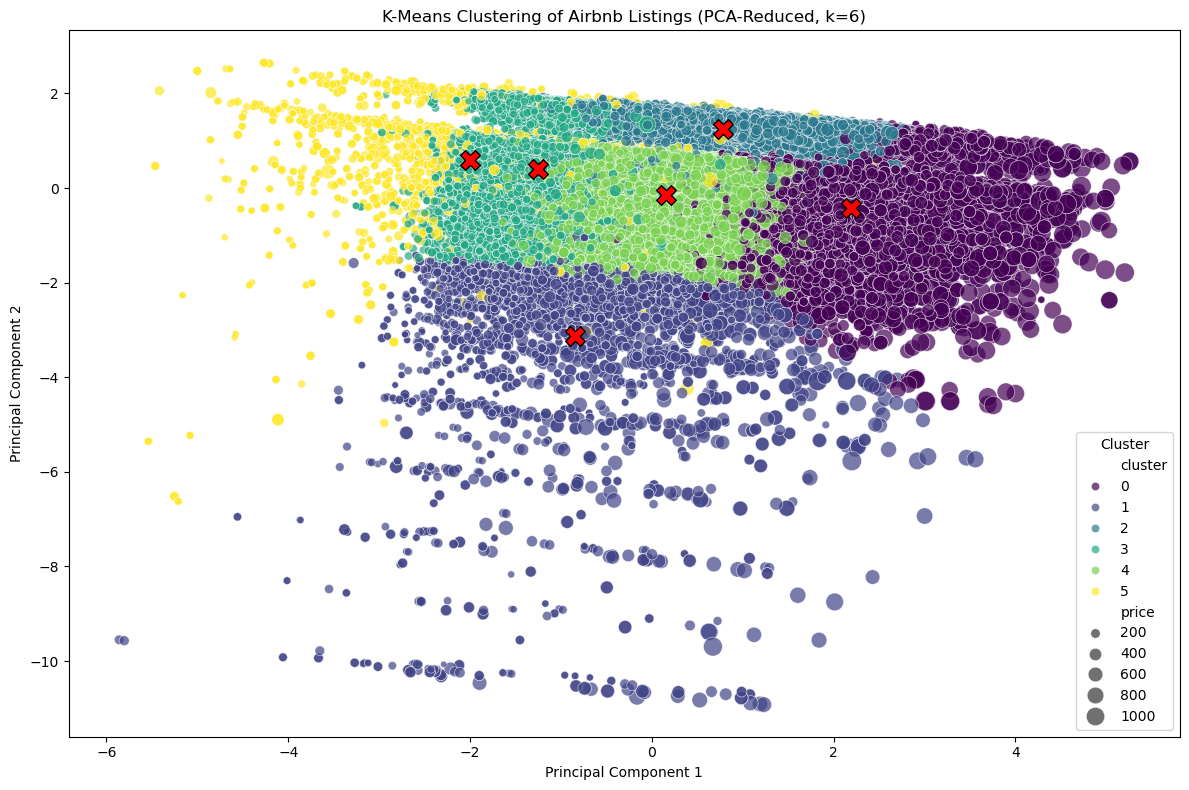

In [20]:
# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a dataframe with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']
pca_df['price'] = df['realSum']

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster',
    size='price',
    sizes=(20, 200),
    palette='viridis',
    data=pca_df,
    alpha=0.7
)

# Add centers to the plot
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=1, marker='X', edgecolor='black')

plt.title(f'K-Means Clustering of Airbnb Listings (PCA-Reduced, k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Save Clustered Data

Save the data with cluster assignments for future use, removing any old cluster columns:

In [22]:
df = df.drop(columns=['cluster_4', 'cluster_6'], errors='ignore')  # `errors='ignore'` makes it safe if they don't exist
df.to_csv("../data/clustered_airbnb.csv", index=False)

## Reflection and Conclusions

### Summary of Work

In this project, we applied KMeans clustering to Airbnb data to uncover meaningful groupings among listings. Specifically, we:

* Determined the optimal number of clusters using an improved elbow method
* Identified distinct groups of similar properties based on shared features
* Created visualizations to highlight what defines each cluster, such as price, location, or guest satisfaction
* Explored the impact of normalization, where pre-normalization suggested 3–4 clusters, but post-normalization revealed six clearer groups due to balanced feature contributions
* Examined how careful feature selection improved clustering, as removing less meaningful variables (such as isWeekend, multi\_bool, room\_shared\_bool, biz\_bool, room\_type) helped reveal stronger underlying patterns

### Practical Relevance

These findings have important practical implications:

For **hosts**:

* Understand where a property fits within the local market landscape
* Set more competitive prices by comparing to similar listings
* Identify which improvements could move a listing into a higher-value cluster

For **guests**:

* Quickly identify listings that best match personal preferences
* Better understand what to expect at different price levels
* Recognize which features typically come bundled together

For **Airbnb as a platform**:

* Enhance property recommendation algorithms
* Analyze differences in market dynamics across cities
* Identify underserved segments or emerging market opportunities

### Opportunities for Future Work

Looking ahead, several extensions could deepen these insights:

* Perform text analysis on property descriptions, reviews, or amenities to enrich cluster profiles
* Track how clusters evolve over time, revealing shifts in the market
* Map clusters geographically within each city to uncover spatial patterns
* Explore sub-clustering within large groups to identify even more granular patterns

The clustered dataset has been saved and is ready for these follow-up analyses, providing a strong foundation for both further research and real-world business applications.
